Test for models.

Linear Model test

In [1]:
import pandas as pd
import sys

sys.path.append('../Models')
from Linear import LinearRegression

In [2]:
Data_train = pd.read_csv(
    "../Data/train.csv",
    parse_dates=["Date"]
)

net demand is the label we want to predict

In [3]:
# train/validation split
X = Data_train.drop(columns=["Net_demand", "Date"])
y = Data_train["Net_demand"]

X_train = X.iloc[:int(0.8*len(X))]
y_train = y.iloc[:int(0.8*len(y))]
X_val = X.iloc[int(0.8*len(X)):]
y_val = y.iloc[int(0.8*len(y)):]


In [4]:
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values

# Normalization
X_mean = X_train_np.mean(axis=0)
X_std = X_train_np.std(axis=0)

X_std[X_std == 0] = 1.0 # avoid X/0

X_train_np = (X_train_np - X_mean) / X_std
X_val_np = (X_val_np - X_mean) / X_std


In [5]:
model = LinearRegression(learning_rate=1e-2, maxIter=1000)
model.fit(X_train_np, y_train_np)

In [6]:
import numpy as np

In [7]:
y_val_pred = model.predict(X_val_np)
val_rmse = np.sqrt(np.mean((y_val_np - y_val_pred) ** 2))
print("Validation RMSE:", val_rmse)


Validation RMSE: 957.2169618918381


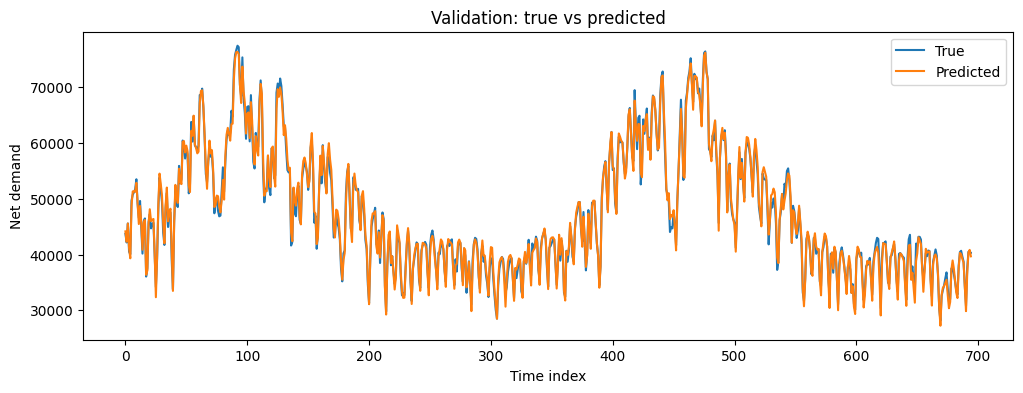

In [8]:
# plot
import matplotlib.pyplot as plt
y_val_pred = model.predict(X_val_np)

plt.figure(figsize=(12, 4))
plt.plot(y_val_np, label="True")
plt.plot(y_val_pred, label="Predicted")
plt.legend()
plt.xlabel("Time index")
plt.ylabel("Net demand")
plt.title("Validation: true vs predicted")
plt.show()


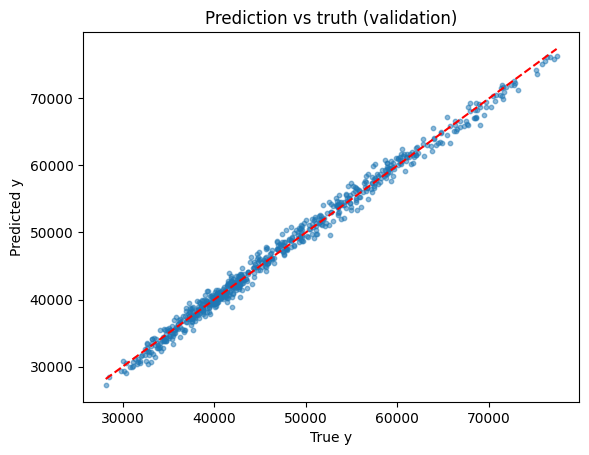

In [9]:
plt.figure()
plt.scatter(y_val_np, y_val_pred, s=10, alpha=0.5)
plt.plot(
    [y_val_np.min(), y_val_np.max()],
    [y_val_np.min(), y_val_np.max()],
    "r--"
)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Prediction vs truth (validation)")
plt.show()


LR: 0.00010, Train RMSE: 6933.0348, Val RMSE: 6971.4741
LR: 0.00012, Train RMSE: 4638.1514, Val RMSE: 4702.6443
LR: 0.00015, Train RMSE: 2996.0559, Val RMSE: 3124.5073
LR: 0.00018, Train RMSE: 2016.3446, Val RMSE: 2228.1043
LR: 0.00022, Train RMSE: 1565.5013, Val RMSE: 1829.7498
LR: 0.00027, Train RMSE: 1387.7588, Val RMSE: 1654.3713
LR: 0.00033, Train RMSE: 1292.4432, Val RMSE: 1535.0190
LR: 0.00040, Train RMSE: 1213.1052, Val RMSE: 1423.7220
LR: 0.00049, Train RMSE: 1137.0826, Val RMSE: 1315.2304
LR: 0.00060, Train RMSE: 1062.7120, Val RMSE: 1210.7691
LR: 0.00073, Train RMSE: 989.0851, Val RMSE: 1110.6867
LR: 0.00089, Train RMSE: 914.8814, Val RMSE: 1014.1862
LR: 0.00108, Train RMSE: 838.5864, Val RMSE: 919.7863
LR: 0.00132, Train RMSE: 758.8960, Val RMSE: 825.8035
LR: 0.00161, Train RMSE: 675.1066, Val RMSE: 730.8291
LR: 0.00196, Train RMSE: 587.3847, Val RMSE: 634.1337
LR: 0.00240, Train RMSE: 496.9000, Val RMSE: 535.9866
LR: 0.00292, Train RMSE: 405.8603, Val RMSE: 437.8998
LR: 0.

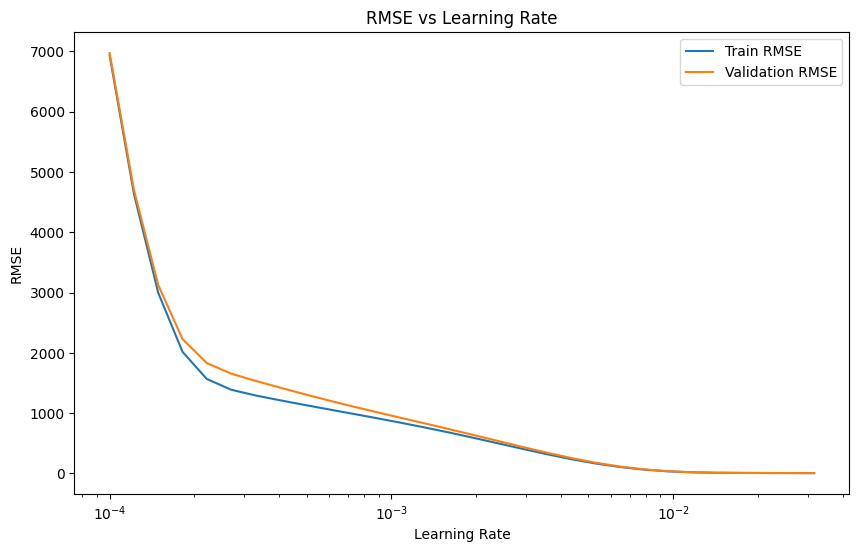

In [19]:
# different learning rates to see overfitting
learning_rates = np.logspace(-4, -1.5, 30)
max_iterations = 10000
results_train = {}
results_val = {}

# visualize overfitting results in train and validation
for lr in learning_rates:
    model = LinearRegression(learning_rate=lr, maxIter=max_iterations)
    model.fit(X_train_np, y_train_np)

    y_train_pred = model.predict(X_train_np)
    train_rmse = np.sqrt(np.mean((y_train_np - y_train_pred) ** 2))
    results_train[lr] = train_rmse

    y_val_pred = model.predict(X_val_np)
    val_rmse = np.sqrt(np.mean((y_val_np - y_val_pred) ** 2))
    results_val[lr] = val_rmse
    print(f"LR: {lr:.5f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

best = min(results_val, key=results_val.get)
print(f"Best learning rate: {best}, with Validation RMSE: {results_val[best]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(list(results_train.keys()), list(results_train.values()), label="Train RMSE")
plt.plot(list(results_val.keys()), list(results_val.values()), label="Validation RMSE")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.title("RMSE vs Learning Rate")
plt.legend()
plt.show()

In [49]:
Data_test = pd.read_csv(
    "../Data/test.csv",
    parse_dates=["Date"]
)

In [ ]:
# colomn differences in Data_train and Data_test
trainCol = set(Data_train.columns)
testCol = set(Data_test.columns)

print("Columns in train but not in test:", trainCol - testCol)
print("Columns in test but not in train:", testCol - trainCol)

Columns in train but not in test: {'Solar_power', 'Wind_power', 'Load', 'Net_demand'}
Columns in test but not in train: {'Usage', 'Id'}


In [ ]:
# load test data and predict on it. The result is a data
# For every day in the dataset, submission file should contain two columns 'Id' and 'Net_demand' separated with a comma. The file should contain a header and have the following format: Id, Net_demand
# Columns in train but not in test: {'Solar_power', 'Wind_power', 'Load', 'Net_demand'}
# Columns in test but not in train: {'Usage', 'Id'}

# note that train has net demand but also load solar and wind power columns that test does not have !!!
# we start over without these informations !

X_train = Data_train.drop(columns=["Net_demand", "Date", "Solar_power", "Wind_power", "Load"])
y_train = Data_train["Net_demand"]
X_test = Data_test.drop(columns=["Date", "Usage", "Id"])
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values

# Normalization
X_mean = X_train_np.mean(axis=0)
X_std = X_train_np.std(axis=0)
X_std[X_std == 0] = 1.0 # avoid X/0
X_train_np = (X_train_np - X_mean) / X_std
X_test_np = (X_test_np - X_mean) / X_std
model = LinearRegression(learning_rate=e-2, maxIter=5000)
model.fit(X_train_np, y_train_np)
y_test_pred = model.predict(X_test_np)

submission = pd.DataFrame({
    "Id": Data_test["Id"],
    "Net_demand": y_test_pred
})

submission

,Id,Net_demand
0,1,40058.755489
1,2,35516.473498
2,3,29635.919204
3,4,36076.265684
4,5,40177.982247
...,...,...
390,391,38746.848528
391,392,38136.693632
392,393,35885.846606
393,394,34850.909528


In [ ]:
# save csv in ../Results/naive_linear_submission.csv
submission.to_csv("../Results/naive_rmse_linear_regression.csv", index=False)
